#**Importando las librerias necesarias**

In [0]:
import pandas as pd
import numpy as np
import spacy 
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.utils import to_categorical
from keras.models import Model, Input,Sequential
from keras import layers 
import nltk #Se usará para obtener los fonemas 
import string #Necesario para manejar los caracteres especiales
import gensim #Libreria para realizar el doc2vec https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-lee.ipynb
from sklearn.feature_extraction.text import CountVectorizer #Utilizado para la creación del bag of phonemes
from sklearn.decomposition import PCA
import random
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [0]:
nltk.download('cmudict')
arpabet = nltk.corpus.cmudict.dict() #Instancia del objeto a utilizar para obtener los fonemas

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


In [0]:
!python -m spacy download en_core_web_sm  # Descargamos el modelo de spacy a utilizar
nlp = spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


#**Obteniendo la data**

###**Montanto el drive para leer el documento que contiene la data, descargado de https://www.kaggle.com/viccalexander/kanyewestverses**

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Diplomado ML/Diseño de Chatbots Conversacional/TA"

###**Leyendo el txt**

In [0]:
#Abriendo el archivo que contiene las rimas 
with open('kanye_verses.txt','r',encoding='ascii',errors='ignore') as txt:
  data=txt.read()

In [0]:
#Obtencion de todos los caracteres para compararlos con las palabras que se obtendran sus fonemas y estas(palabras) no sean caracteres especiales
all_punct=[punct for punct in string.punctuation] 

#**Creación del dataset a partir del txt**

In [0]:
def gettingFeatures(nlp,sentence,arpabet,num_words):
  """Funcion para obtener las caracteristicas de las ultimas palabras usando Spacy y el diccionario pra los fonemas.

  Parametros: 
              - nlp:Modelo descargado de Spacy
              - sentence:Sentencia que se desea obtener sus caracteristicas
              - arpabet:Modelo descargado de NLTK para la obtencion de los fonemas
              - num_words:Cantidad de ultimas palabras de las que se quieren obtener sus caracteristicas
  Retorna: Una tupla con las caracteristicas obtenidas.
  """
  doc=nlp(sentence)
  last_words,phonemes,tag,dep=([] for _ in range(4))
  for token in reversed(list(doc)): #Revertimos para ir desde las ultimas palabras hacia las primeras
    if token.text not in all_punct: #Verificamos si la palabra no pertence a un caracter especial
      last_words.append(token.text.lower()) #Convertimos a minisculas porque será una llave en el diccionario de fonemas
      #Debido a que arpabet es un diccionario(llave:palabra, valor:fonemas) es posible que la palabra ingresada no se encuentre en esta,
      #por eso verificamos
      try:
        phon=arpabet[token.text.lower()][0]
      except Exception as e:
        phon='NA'
      phonemes.append(phon)
      tag.append(token.tag_)
      dep.append(token.dep_)
    if len(last_words) == num_words: #cantidad de ultimas palabras
      break


  #La variable phonemes es una lista de listas, aplanaremos esto  
  flatten_phonemes=[phon for phons in phonemes for phon in phons]

  return last_words," ".join(flatten_phonemes)," ".join(tag)," ".join(dep)

  

In [0]:
gettingFeatures(nlp,"""(Ball so hard) That shit cray, ain’t it Jay? What she order, fish Filet?""",arpabet,4)

(['filet', 'fish', 'order', 'she'],
 'F IH0 L EY1 F IH1 SH AO1 R D ER0 SH IY1',
 'NNP VB VBP PRP',
 'dobj ROOT advcl nsubj')

In [0]:
#Creando el dataframe a partir del archivo, auqnue tambien se ha creado internamente un diccionario
def creatingDf(data):
  """Función que servirá para crear un dataFrame a partir de la data leida en el txt.

  Función que recibe la data del txt y la recorre dividiendola en versos y posteriormente en sentencias(rimas)
  hace uso de la funcion gettingFeatures para obtener los parametros y a partir de esto crear un dataframe.

  Parámetros:
              -data: Data leida previamente del txt.
  
  Retorna: Un dataframe con las caracteristicas que se obtuvieron por la función gettingFeatures
  """
  
  verses=list(filter(None,data.split('\n\n'))) #Division de la data en versos
  
  df=pd.DataFrame(columns=['Verses','Rhymes','Target','Rhyme','Last_Words','Tag','Dep','Phonemes']) #Instancia del dataframe
  
  dic_verses={} #Tambien se tiene la data en un diccionario pero se complico la creacion de un dataframe a partir de esto
  
  for index,verse in enumerate(verses): #Recorrer los versos para obtener las oraciones
    
    dic_rhymes={} #diccionario de las rimas (oraciones)
    
    rhymes=verse.split('\n') # Separacion de las rimas en oraciones
    #La creacion de una variable de apoyo es necesiario para poder lograr relacionar una rima con otra que le continue
    j=1
    for i,rhyme in enumerate(rhymes):
      if (i+1) % 2 == 0:
        j-=1
      dic_rhymes[f'Rhyme {i+1}']=rhyme #relacionado al diccionario general
      
      #No se quitarán los caracteres especiales de las rimas porque estas seran las respuestas mas adelante.
      
      features=gettingFeatures(nlp,rhyme,arpabet,1) #Llamando a la funcion para obtener las caracteristicas de las sentencias
      #Agregando una fila al dataFrame
      #Obtener mas caracteristicas a partir de la clase que de POS
      #Obtener los fonemas de esa palabra usando NLTK
      #Obtener las silabas 
      df=df.append({'Verses':f'Verse {index+1}',
                 'Rhymes': f'Rhyme {j}',
                 'Target': f'Verse {index+1} Rhyme {j}',
                 'Rhyme' : rhyme,
                 'Last_Words': features[0],
                 'Phonemes': features[1],
                 'Tag' : features[2],
                 'Dep' : features[3]
                }, ignore_index=True) 
        
      j+=1
    dic_verses[f'Verse {index+1}']=dic_rhymes #relacionado al diccionario general    
  return df    
    
  

In [0]:
rpt=creatingDf(data)

In [0]:
rpt[rpt.Verses == 'Verse 1'].head()

,Verses,Rhymes,Target,Rhyme,Last_Words,Tag,Dep,Phonemes
0,Verse 1,Rhyme 1,Verse 1 Rhyme 1,Let the suicide doors up,[up],RP,prt,AH1 P
1,Verse 1,Rhyme 1,Verse 1 Rhyme 1,I threw suicides on the tour bus,[bus],NN,pobj,B AH1 S
2,Verse 1,Rhyme 2,Verse 1 Rhyme 2,I threw suicides on the private jet,[jet],NN,pobj,JH EH1 T
3,Verse 1,Rhyme 2,Verse 1 Rhyme 2,"You know what that mean, I'm fly to death",[death],NN,pobj,D EH1 TH
4,Verse 1,Rhyme 3,Verse 1 Rhyme 3,I step in Def Jam buildin' like I'm the shit,[shit],NN,attr,SH IH1 T


#**Creación del doc2vec**

In [0]:
def usingGensim(doc,tag=None,test=False):
  """Función para tokenizar y agregar un tag a la sentencia haciendo uso de Gensim.

  Función para los datos del train y del test, hace uso de la funcion simple_preprocess para la tokenizacion y TaggedDocument para tagearlos.
  Si se trata de la data de entrenamiento, tokenizará y tageará la sentencia para esto se debe pasar el parametro tag, si se trata de la data 
  de prueba entonces solo se tokenizará y se deberá cambiar el parametro test a True.
  Parámetros:
              - doc: Sentencia que se quiere tokenizar y tagear (entrenamiento).
              - tag: Tag que se le asignará a la sentencia si sobre la data de entrenamiento.
              - test: Flag para saber si es sobre la data de prueba o de entrenamiento.
  Retorna: Una lista con los tokens de la sentencia si es para el test y un objeto TaggedDocument con los tokens y el tag si es para data de prueba.
  """
  #Si es para el doc de prueba entonces no se le pasa el tag, porque esta no se conoce
  #En un inicio se pensó que el tag influia en los vectores, pero es un index para luego poder encontrar el texto. NO INFLUYE EN LA REPRESENTACION VECTORIAL
  #Entonces el tag va a ser la posicion(index) de la rima dentro del dataframe
  if test:
    return gensim.utils.simple_preprocess(doc) #Devuelve el doc tokenizado
  else:
    return gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(doc), [tag])#Devuelve el doc tokenizado con su tag

In [0]:
usingGensim('(Ball so hard) That shit cray, ain’t it Jay? What she order, fish Filet?',tag=1)

TaggedDocument(words=['ball', 'so', 'hard', 'that', 'shit', 'cray', 'ain', 'it', 'jay', 'what', 'she', 'order', 'fish', 'filet'], tags=[1])

**Creación del doc2vec a partir de la columna Rhyme del dataframe**

In [0]:
#Creacion del taggedDocuments
taggedDocuments=[]
for index in range(len(rpt.Rhyme)):
  taggedDocuments.append(usingGensim(rpt.Rhyme[index],tag=index)) #El tag será el index de cada fila para poder ubicarla mas adelante

In [0]:
taggedDocuments[:5]

[TaggedDocument(words=['let', 'the', 'suicide', 'doors', 'up'], tags=[0]),
 TaggedDocument(words=['threw', 'suicides', 'on', 'the', 'tour', 'bus'], tags=[1]),
 TaggedDocument(words=['threw', 'suicides', 'on', 'the', 'private', 'jet'], tags=[2]),
 TaggedDocument(words=['you', 'know', 'what', 'that', 'mean', 'fly', 'to', 'death'], tags=[3]),
 TaggedDocument(words=['step', 'in', 'def', 'jam', 'buildin', 'like', 'the', 'shit'], tags=[4])]

In [0]:
#Instanciamos el modelo Doc2Vec con un tamaño de 50 para el vector
modelDoc2Vec = gensim.models.doc2vec.Doc2Vec(vector_size=50, epochs=40)

In [0]:
#Construimos el vocabulario
modelDoc2Vec.build_vocab(taggedDocuments)

In [0]:
#Entrenamos el modelo
%time modelDoc2Vec.train(taggedDocuments, total_examples=modelDoc2Vec.corpus_count, epochs=modelDoc2Vec.epochs)

CPU times: user 16.2 s, sys: 4.31 s, total: 20.5 s
Wall time: 14.1 s


#**Creación del bag of phonemes(basado en el modelo bag of words)**

**Este bag of phoenemes será el input de nuestro modelo clasificador**

In [0]:
#Creando el bag of phonemes
cv=CountVectorizer()
X=cv.fit_transform(rpt['Phonemes']).toarray()

In [0]:
#Representacion de los phonemes en un sparse matrix 
X[:2]

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]])

#**REDUCCION DE LA DIMENSIONALIDAD CON PCA Y CLUSTERIZACION PARA LAS RIMAS**

**Se aplicará PCA para reducir las dimensiones del Bag of Phonemes a 2 con el fin de visualizar como se encuentran estos puntos y decidir si se puede clusterizar o no**

##**Reduccion de la dimensionalidad**

In [0]:
pca=PCA(n_components=2)
Xpca=pca.fit_transform(X) # X reducido a 2 dimensiones

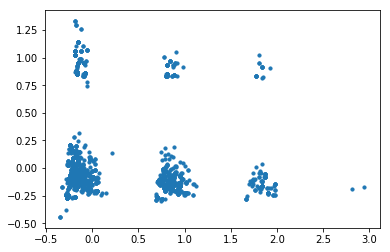

In [0]:
plt.scatter(Xpca[:,0],Xpca[:,1],s=10) 

In [0]:
pca.explained_variance_ratio_.sum() #Esta suma puede ser baja pero muchas veces basta con solo 2 para poder clusterizar y eso nos dice el gráfico anterior

0.20368194543636178

##**Clusterizacion con GaussianMixture**

In [0]:
from sklearn.mixture import GaussianMixture
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(Xpca)
             for k in range(1, 20)]

In [0]:
bics = [model.bic(Xpca) for model in gms_per_k]
aics = [model.aic(Xpca) for model in gms_per_k]

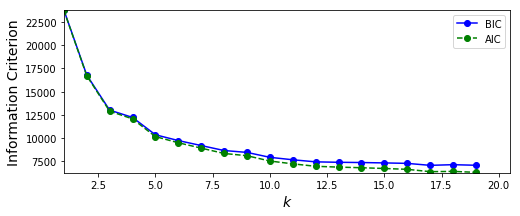

In [0]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 20), bics, "bo-", label="BIC")
plt.plot(range(1, 20), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 20.5, np.min(aics) - 50, np.max(aics) + 50])
plt.legend()
plt.show()

In [0]:
min_bic = np.infty

for k in range(1, 20):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(Xpca).bic(Xpca)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [0]:
best_k,best_covariance_type

(17, 'full')

In [0]:
GMM=GaussianMixture(n_components=17, n_init=20, random_state=42,covariance_type='tied').fit(Xpca)

In [0]:
y_pred_GMM=GMM.predict(Xpca)

In [0]:
dfPrueba=pd.DataFrame(Xpca)
dfPrueba['y_pred_GMM']=y_pred_GMM

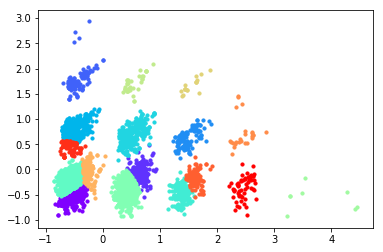

In [0]:
grups=len(set(y_pred_GMM))
x = np.arange(grups)
ys = [i+x+(i*x)**2 for i in range(grups)]
colors = cm.rainbow(np.linspace(0, 1, len(ys)));
for i in range(grups):
  plt.scatter(dfPrueba[0][dfPrueba.y_pred_GMM == i],dfPrueba[1][dfPrueba.y_pred_GMM == i],s=10,c=[colors[i]])

##**Clusterizacion con HDBscan**

In [0]:
!pip install hdbscan

In [0]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=9)
cluster_labels = clusterer.fit_predict(Xpca)

In [0]:
dfPrueba=pd.DataFrame(Xpca)
dfPrueba['y_pred_HDbscan']=cluster_labels

In [0]:
np.unique(cluster_labels)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138])

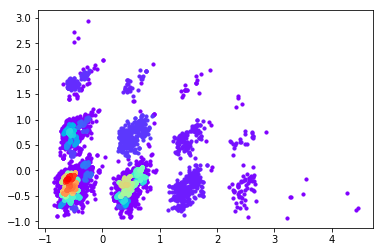

In [0]:
grups=len(set(cluster_labels))
x = np.arange(grups)
ys = [i+x+(i*x)**2 for i in range(grups)]
colors = cm.rainbow(np.linspace(0, 1, len(ys)));
for i in range(grups):
  plt.scatter(dfPrueba[0][dfPrueba.y_pred_HDbscan == i-1],dfPrueba[1][dfPrueba.y_pred_HDbscan == i-1],s=10,c=[colors[i]])
  #Los puntos morados son los que tienen como clase -1 y son considerados como ruido por dbscan, se deverá eliminar esto del dataframe 

##**Clusterizacion con DBscan**

In [0]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(Xpca)
distances, indices = nbrs.kneighbors(Xpca) #Nos devuelve la distancia y los indices

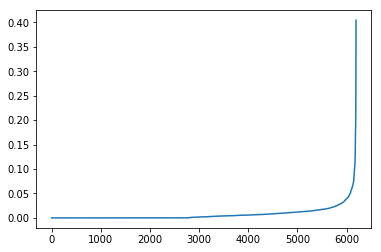

In [0]:
distances = np.sort(distances, axis=0) #Ordenamos y luego graficamos
distances = distances[:,1]
plt.plot(distances)

In [0]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(Xpca)
np.unique(dbscan.labels_),len(np.unique(dbscan.labels_)) #DBScan devuelve -1 para las clases que considera ruido

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7]), 9)

In [0]:
dfPrueba=pd.DataFrame(Xpca)
dfPrueba['y_pred_Dbscan']=dbscan.labels_

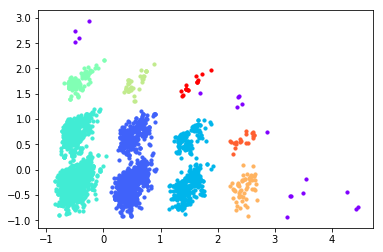

In [0]:
grups=len(set(dbscan.labels_))
x = np.arange(grups)
ys = [i+x+(i*x)**2 for i in range(grups)]
colors = cm.rainbow(np.linspace(0, 1, len(ys)));
for i in range(grups):
  plt.scatter(dfPrueba[0][dfPrueba.y_pred_Dbscan == i-1],dfPrueba[1][dfPrueba.y_pred_Dbscan == i-1],s=10,c=[colors[i]])
  #Los puntos morados son los que tienen como clase -1 y son considerados como ruido por dbscan, se deverá eliminar esto del dataframe 

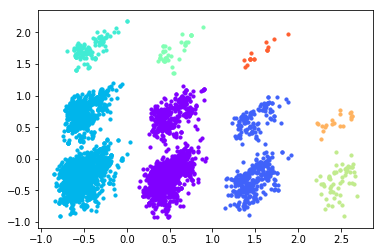

In [0]:
#Grafico sin ruido
grups=len(set(dbscan.labels_))
x = np.arange(grups)
ys = [i+x+(i*x)**2 for i in range(grups)]
colors = cm.rainbow(np.linspace(0, 1, len(ys)));
for i in range(grups):
  plt.scatter(dfPrueba[0][dfPrueba.y_pred_Dbscan == i],dfPrueba[1][dfPrueba.y_pred_Dbscan == i],s=10,c=[colors[i]])
  #Los puntos morados son los que tienen como clase -1 y son considerados como ruido por dbscan, se deverá eliminar esto del dataframe 

**Se trabajará con DBScan y veremos que resultado se obtiene**

In [0]:
rpt['y_pred_Dbscan']=dbscan.labels_

In [0]:
rpt.head()

In [0]:
#Necesitamos eliminar las clases que han sido clasificadas como ruido
rpt[rpt.y_pred_Dbscan == -1]

##**Clusterizacion con BayesianGaussianMixture**

**Esto es solo con fines de visualización**

In [0]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=5, n_init=10, random_state=42,covariance_type='tied') #100
bgm.fit(Xpca)

BayesianGaussianMixture(covariance_prior=None, covariance_type='tied',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=5, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

In [0]:
np.round(bgm.weights_, 2)

array([0.75, 0.12, 0.09, 0.02, 0.02])

In [0]:
y_pred=bgm.predict(Xpca)

In [0]:
dfPrueba=pd.DataFrame(Xpca)
dfPrueba['y_pred']=y_pred

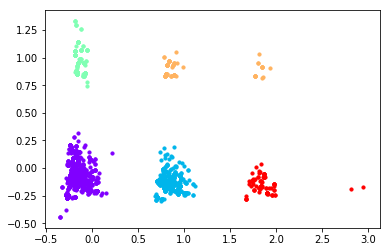

In [0]:
import matplotlib.cm as cm
grups=len(set(y_pred))
x = np.arange(grups)
ys = [i+x+(i*x)**2 for i in range(grups)]
colors = cm.rainbow(np.linspace(0, 1, len(ys)));
for i in range(grups):
  plt.scatter(dfPrueba[0][dfPrueba.y_pred == i],dfPrueba[1][dfPrueba.y_pred == i],s=10,c=[colors[i]])

**Sabemos que las clases de rimas no pueden ser solo 5 entonces se dividirá en multiplos de este y los componentes no pueden ser solo 2 entonces aplicaremos un PCA para quedarnos con 15 componentes**

In [0]:
#Incrementaremos la varianza explicada aumentando la cantidad de componentes
pca=PCA(n_components=15)
Xpca=pca.fit_transform(X) 
pca.explained_variance_ratio_.sum() 

0.7957917386376637

In [0]:
bgm = BayesianGaussianMixture(n_components=100, n_init=10, random_state=42,covariance_type='tied') #100
bgm.fit(Xpca)

BayesianGaussianMixture(covariance_prior=None, covariance_type='tied',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=100, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

In [0]:
y_pred=bgm.predict(Xpca)
#Agregamos la clusterizacion del modelo al dataframe
rpt['y_pred_bgm']=y_pred
rpt.head()

,Verses,Rhymes,Target,Rhyme,Last_Words,Tag,Dep,Phonemes,y_pred_bgm
0,Verse 1,Rhyme 1,Verse 1 Rhyme 1,Let the suicide doors up,[up],RP,prt,AH1 P,4
1,Verse 1,Rhyme 1,Verse 1 Rhyme 1,I threw suicides on the tour bus,[bus],NN,pobj,B AH1 S,4
2,Verse 1,Rhyme 2,Verse 1 Rhyme 2,I threw suicides on the private jet,[jet],NN,pobj,JH EH1 T,0
3,Verse 1,Rhyme 2,Verse 1 Rhyme 2,"You know what that mean, I'm fly to death",[death],NN,pobj,D EH1 TH,0
4,Verse 1,Rhyme 3,Verse 1 Rhyme 3,I step in Def Jam buildin' like I'm the shit,[shit],NN,attr,SH IH1 T,10


# *Preprocesamiento de la data*

In [0]:
#El bag of phonemes es un array pero lo convertiremos en un dataframe con el fin de manejar sus indices, esto nos guiará para realizar las pruebas
df_X=pd.DataFrame(X)
df_X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [0]:
#Obtencion del target
y=rpt.y_pred_bgm.copy()
y.shape

(6192,)

In [0]:
df_X.shape,y.shape

((6192, 49), (6192,))

In [0]:
#Primero convertimos el objetivo en categoria luego convertimos a vectores con la funcion de Keras(to_categorical)
y_not_categorical=y
y=to_categorical(y) #Convierte las clases que son numeros en un arreglo aplicando OneHotEncoding

In [0]:
#Division de la data para el entrenamiento y la prueba
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test =train_test_split(df_X,y,test_size=0.1,random_state=2019,shuffle=True)

# **Modelando**

In [0]:
#Definimos el modelo de red neuronal a usar
def build_model(len_row):

  model=Sequential()
  
  model.add(layers.Dropout(0.1,input_shape=(len_row,)))

  model.add(Dense(120,init='uniform',activation='tanh'))
  
  #model.add(layers.Dropout(0.2))
  
  model.add(Dense(100,init='uniform',activation='softmax'))
  
  
  
  model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy']) # El optimizer está relacionado a los pesos(W) de los nodos de las neuronas
  #model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])
  #categorical_crossentropy,sparse_categorical_crossentropy(No necesita one hot encoding al target)
  #Categorical crossentropy se utiliza cuando el problema es multiclass target, sino es binary crossentropy
  
  return model

In [0]:
model = build_model(X_train.shape[1])
model.summary()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 49)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               6000      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               12100     
Total params: 18,100
Trainable params: 18,100
Non-trainable params: 0
_________________________________________________________________


In [0]:
#Entrenamos la red neuronal
history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test)) # EL loss está relacionado a cuando lejos esta la prediccion de ser correcta

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5572 samples, validate on 620 samples
Epoch 1/10
5572/5572 [==============================] - 9s 2ms/step - loss: 4.3153 - acc: 0.5809 - val_loss: 3.9196 - val_acc: 0.6726
Epoch 2/10
5572/5572 [==============================] - 0s 46us/step - loss: 3.4763 - acc: 0.5772 - val_loss: 2.9691 - val_acc: 0.6113
Epoch 3/10
5572/5572 [==============================] - 0s 33us/step - loss: 2.6225 - acc: 0.6113 - val_loss: 2.2037 - val_acc: 0.6887
Epoch 4/10
5572/5572 [==============================] - 0s 36us/step - loss: 2.0291 - acc: 0.6093 - val_loss: 1.6578 - val_acc: 0.6919
Epoch 5/10
5572/5572 [==============================] - 0s 37us/step - loss: 1.6186 - acc: 0.6290 - val_loss: 1.2686 - val_acc: 0.7210
Epoch 6/10
5572/5572 [==============================] - 0s 36us/step - loss: 1.3303 - acc: 0.6777 - val_loss: 0.9777 - val_acc: 0.7806
Epoch 7/10
5572/5572 [============================

# **Resultados del modelo**

In [0]:
#Creamos una función para graficar el accuracy o loss del entrenamiento
def plot_history(title, train, test, y_title, x_title):
  """Funcion para graficar el accuracy y el loss basandose en lo obtenido al momento de entrenado el modelo.

  Paremtros:
            -title: Título del plot
            -train: Valor del accuracy o loss de la data de entrenamiento
            -test: Valor del accuracy o loss de la data de prueba
            -y_title: Titulo del eje y
            -x_title: Titulo del eje x
  
  Retorna: Retorna el gráfico a partir de los parametros ingresados.
  """
  plt.title(title)
  plt.plot(train)
  plt.plot(test)
  plt.ylabel(y_title)
  plt.xlabel(x_title)
  plt.legend(['Train', 'Test'])
  plt.show()

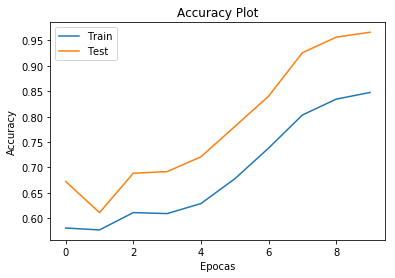

In [0]:
#Visualizamos el accuracy
plot_history("Accuracy Plot", history.history['acc'], history.history['val_acc'], "Accuracy", "Epocas")

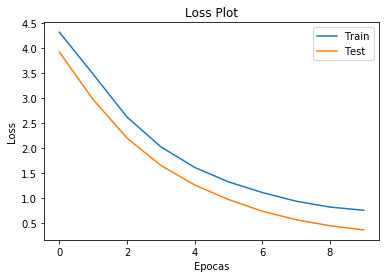

In [0]:
#Visualizamos el loss
plot_history("Loss Plot", history.history['loss'], history.history['val_loss'], "Loss", "Epocas")

# **Predicciones con el modelo**

In [0]:
def makeResponse(input_sentence):
  """Funcion que responde al mensaje ingresado con una rima del dataset.
  """
  df_test=creatingDf(input_sentence)#Obtencion de sus caracteristicas
  bag_of_word_input=cv.transform(df_test.Phonemes).toarray() #Representacion de sus fonemas a traves de un arreglo
  input_prediction=model.predict_classes(bag_of_word_input)  #Prediccion de la clase de la frase ingresada
  #Obtenemos sus index para filtrar nuestra busqueda en el doc2vec
  index=rpt[rpt.y_pred_bgm == input_prediction[0]].index

  #Ahora tokenizamos sentencia
  tokens_gensim=usingGensim(input_sentence,test=True)
  #Obtenemos su representacion en vector
  input_vector = modelDoc2Vec.infer_vector(tokens_gensim)
  #Las similitudes que tiene la frase ingresada con todas las rimas, nos da como resultado una lista de tuplas, la tupla esta compuesta por el indice y su similiradad con la frase
  sims=modelDoc2Vec.docvecs.most_similar([input_vector], topn=len(taggedDocuments))
  #Recorremos cada tupla hasta encontrar los 10 primeros que mas se parecen y que tienen la misma clase
  index_most_simi=[]
  for tupla in sims:
    if tupla[0] in list(index): #Solo si el indice de la tupla se encuentra entre los indices hallados anteriormente
      index_most_simi.append(tupla)
      if len(index_most_simi) == 15:
        break
  
  rand_index=random.randrange(0, 15)
  #Por ultimo usamos ese indice para obtener la rima
  return rpt.Rhyme[rpt.index == index_most_simi[rand_index][0]].values[0]


In [0]:
print(makeResponse("How are you?"))

I'm talkin' Montell Jordan, this is how we do


#**Construccion del chatbot**

**Intents asociados a sentencias**

In [0]:
dataset = """
*greet
Hi
Hello
Hey there

*affirm
Yes
Love it
Yeah
Yep

*negation
No
No, I don't 
Not at the moment
Not really

*stop
stop
quit
"""

**Metodos para crear el dataset**

In [0]:
def filter_intents_and_their_examples(dataset, intent_character = "*"):
  filter_list = list(filter(None, dataset.split("\n")))
  intents_examples = {}
  intent = ""
  for element in filter_list:
    if element[0] == intent_character:
      intent = element[1:]
    else:
      if intent not in intents_examples:
        intents_examples[intent] = [element]
      else:
        intents_examples[intent].append(element)
  return intents_examples

def transform_examples_in_vectors(intents_examples, nlp):
  intents_vector_examples = {}
  for key, values in intents_examples.items():
    vector_examples = []
    for example in values:
      vector_examples.append(nlp(example).vector)
    
    intents_vector_examples[key] = vector_examples
  return intents_vector_examples

def create_x_and_y(intents_vector_examples):
  x = []
  y = []
  for label, vector_examples in intents_vector_examples.items():
    x.extend(vector_examples)
    y.extend([label] * len(vector_examples))
  
  return x, y

**Creando el dataset**

In [0]:
#Obteniendo un diccionario de intents con sus sentencias
intents_examples = filter_intents_and_their_examples(dataset)

#Transformando las sentencias a vectores en el diccionario
intents_vector_examples = transform_examples_in_vectors(intents_examples, nlp)

#Obteniendo los nombres de los intents
intents = list(intents_vector_examples.keys())

#Obteniendo x,y para entrenar un modelo de Machine Learning
x, y = create_x_and_y(intents_vector_examples)

In [0]:
intents_examples

{'affirm': ['Yes', 'Love it', 'Yeah', 'Yep'],
 'greet': ['Hi', 'Hello', 'Hey there'],
 'negation': ['No', "No, I don't ", 'Not at the moment', 'Not really'],
 'stop': ['stop', 'quit']}

**Entrenando el modelo que predecirá los intents**

In [0]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(x, y)

#Evaluacion del accuracy
accuracy = decision_tree_classifier.score(x, y)
accuracy

1.0

**Metodo que realizará la prediccion del intent**

In [0]:
def predict_intent(sentence, nlp, model):
  vector = nlp(sentence).vector
  
  intent = model.predict([vector])
  return intent[0]

**Utterance asociados a sentencias**

In [0]:
dataset = """
*greet
Hey, what's up buddy ? Do you wanna rhyme ?
How is it goin' bud ? Do you wanna play with some rhymes? 
Zup my nigga ? Would you like rap with me ?

*affirm
Alright, so just gimme a sentence and I'll continue with a rhyme .
Awesome, show me what you got and I'll rhyme that.
K, let's see what you got.

*negation
Hahaha it seems there's a coward around here. So come back as soon as possible.
Alright, go to get warm and come back soon.
K, no worries. Hope see ya soon.

*goodbye
That was exciting, I had fun dude. Take care man.
You did really good my homie, Hope see ya soon.
That was funny, I'll wait for your rhymes man.
"""

In [0]:
def filter_utterances_and_their_examples(dataset, utterance_character = "*"):
  filter_list = list(filter(None, dataset.split("\n")))

  utterances_examples = {}
  utterance = ""
  for element in filter_list:
    if element[0] == utterance_character:
      utterance = element[1:]
    else:
      if utterance not in utterances_examples:
        utterances_examples[utterance] = [element]
      else:
        utterances_examples[utterance].append(element)
  return utterances_examples

In [0]:
#Obteniendo un diccionario de utterances con sus sentencias
utterances_examples = filter_utterances_and_their_examples(dataset)
utterances_examples

{'affirm': ["Alright, so just gimme a sentence and I'll continue with a rhyme .",
  "Awesome, show me what you got and I'll rhyme that.",
  "K, let's see what you got."],
 'goodbye': ['That was exciting, I had fun dude. Take care man.',
  'You did really good my homie, Hope see ya soon.',
  "That was funny, I'll wait for your rhymes man."],
 'greet': ["Hey, what's up buddy ? Do you wanna rhyme ?",
  "How is it goin' bud ? Do you wanna play with some rhymes? ",
  'Zup my nigga ? Would you like rap with me ?'],
 'negation': ["Hahaha it seems there's a coward around here. So come back as soon as possible.",
  'Alright, go to get warm and come back soon.',
  'K, no worries. Hope see ya soon.']}

**Definimos las reglas de intents con utterances**

In [0]:
rules = {
    "greet": "greet",
    "negation": "negation",
    "affirm": "affirm",
    "stop": "goodbye"
}

In [0]:
from random import choice

def generate_answer(utterance, utterances_examples):
  answers = utterances_examples[utterance]
  answer = choice(answers)
  return answer

In [0]:
def return_answer(sentence, nlp, model, rules, utterances_examples):
  intent = predict_intent(sentence, nlp, decision_tree_classifier)
  
  utterance = rules[intent]
  
  answer = generate_answer(utterance, utterances_examples)
  return answer, intent

In [0]:
intent=None
while True:
  sentence = input()
  answer, intent = return_answer(sentence, nlp, decision_tree_classifier, rules, utterances_examples)
  print("bot says: {}\n".format(answer))
  if intent == 'affirm':
    while True: 
       sentence=input()
       rhyme=makeResponse(sentence)
       if sentence == 'stop':
         intent='stop'
         answer, intent = return_answer(sentence, nlp, decision_tree_classifier, rules, utterances_examples)
         print("bot says: {}\n".format(answer))
         break
       print("bot says: {}\n".format(rhyme))

  if intent == 'negation' or intent=='stop':
    break
  

  
  

Hi
bot says: Hey, what's up buddy ? Do you wanna rhyme ?

yep
bot says: Awesome, show me what you got and I'll rhyme that.

Let's do it
bot says: Brothers can't hack it

How do you know that ?
bot says: That you got that bag

What r you talking about ?
bot says: I say fuck the police, that's how I treat 'em

That was funny !!
bot says: Get money, money, money, money

do you like money?
bot says: Get money, money, money, money

I like it too
bot says: Me too

We have some stuff in common 
bot says: PETA's mad cause I made a jacket outta possum

Nice
bot says: Seven o'clock, that's primetime

stop
bot says: That was funny, I'll wait for your rhymes man.

